# Return Analysis

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py
# 初始化离线模式
py.init_notebook_mode(connected=True)

In [2]:
tag = 'EURUSD'
# 定义要计算的时间间隔
time_intervals = [1, 5, 10, 60, 300, 600, 1800, 3600]

In [3]:
# 读取CSV文件
news_scores = pd.read_csv(f'result/{tag}_news_scores.csv')
price_data = pd.read_csv(f'price/{tag}.csv')

# 将Created Date转换为datetime类型，并去除时区信息
news_scores['Created Date'] = pd.to_datetime(news_scores['Created Date']).dt.tz_localize(None)
news_scores['Created Date'] = news_scores['Created Date'].dt.floor('min')  # 将时间向下取整到分钟

news_scores = news_scores.rename(columns={'Created Date': 'createDate'})

def calculate_min(row):
    return min(row['FinBERT_sentiment_title'], row['ABSA_Bert_sentiment_title_EUR'], row['Vader_sentiment_title'])
def calculate_max(row):
    return max(row['FinBERT_sentiment_title'], row['ABSA_Bert_sentiment_title_EUR'], row['Vader_sentiment_title'])
def calculate_avg(row):
    return (row['FinBERT_sentiment_title'] + row['ABSA_Bert_sentiment_title_EUR'] + row['Vader_sentiment_title'])/3
news_scores['min_sentiment_title'] = news_scores.apply(calculate_min, axis=1)
news_scores['max_sentiment_title'] = news_scores.apply(calculate_max, axis=1)
news_scores['average_sentiment_title'] = news_scores.apply(calculate_avg, axis=1)
# 将datetime转换为datetime类型
price_data['datetime'] = pd.to_datetime(price_data['datetime'])
# 将price_data设置为以datetime为索引
price_data.set_index('datetime', inplace=True)


# Convert price columns to float
price_data['close'] = pd.to_numeric(price_data['close'], errors='coerce')
price_data['open'] = pd.to_numeric(price_data['open'], errors='coerce')
price_data['high'] = pd.to_numeric(price_data['high'], errors='coerce')
price_data['low'] = pd.to_numeric(price_data['low'], errors='coerce')



# 定义计算收益的函数
def calculate_returns(row, n, price_data):
    current_time = row['createDate']
    future_time = current_time + pd.Timedelta(minutes=n)
    
    try:
        current_close = price_data.loc[current_time, 'close']
        current_open = price_data.loc[current_time, 'open']
        future_close = price_data.loc[future_time, 'close']
        future_open = price_data.loc[future_time, 'open']
        
        r_close = (future_close - current_close) / current_close
        r_open = (future_open - current_open) / current_open
        
        return pd.Series({'r_{}'.format(n): r_close, 'r_open_{}'.format(n): r_open})
    except KeyError:
        return pd.Series({'r_{}'.format(n): np.nan, 'r_open_{}'.format(n): np.nan})

# 计算不同时间间隔的收益
for n in time_intervals:
    news_scores = news_scores.join(news_scores.apply(lambda row: calculate_returns(row, n, price_data), axis=1))

# 保存结果到新的CSV文件
news_scores.to_csv(f'result/{tag}_scores_returns.csv', index=False)

In [4]:
df = news_scores.dropna().copy()

close_list = [f'r_{n}' for n in time_intervals]
open_list = [f'r_open_{n}' for n in time_intervals]
columns_to_process = close_list + open_list

for col in columns_to_process:
    new_col = f"{col}_v"
    
    # 创建新列，初始值与原列相同
    df[new_col] = 0
    
    # 对 Vader_sentiment_title 小于 0 的行，新列的值乘以 -1
    mask = df['Vader_sentiment_title'] < 0
    df.loc[mask, new_col] = df.loc[mask, col]*-1

    mask = df['Vader_sentiment_title'] > 0
    df.loc[mask, new_col] = df.loc[mask, col]

# 验证结果
df.head()

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/1708959868.py:15: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 9.38438438e-05 -9.29368030e-05 -0.00000000e+00  9.29713648e-05
 -1.85701021e-04 -0.00000000e+00 -9.28332714e-05  9.24470741e-05
 -0.00000000e+00  9.18779860e-05 -9.21319329e-05 -9.21234454e-05
 -9.21743940e-05  9.17347032e-05  9.19033177e-05 -0.00000000e+00
 -9.31272118e-05 -0.00000000e+00 -0.00000000e+00 -9.31358853e-05
 -0.00000000e+00  9.35628743e-05 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -9.31445604e-05 -0.00000000e+00  9.31272118e-05
  9.25154963e-05 -0.00000000e+00 -9.23872875e-05 -0.00000000e+00
 -9.25240563e-05  9.24641701e-05  9.24556213e-05 -9.24214418e-05
 -0.00000000e+00 -9.18526683e-05 -0.00000000e+00 -1.83435752e-04
 -0.00000000e+00 -0.00000000e+00  9.18526683e-05 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.000

,createDate,Title,Tag,FinBERT_sentiment_title,ABSA_Bert_sentiment_title_EUR,Vader_sentiment_title,min_sentiment_title,max_sentiment_title,average_sentiment_title,r_1,...,r_1800_v,r_3600_v,r_open_1_v,r_open_5_v,r_open_10_v,r_open_60_v,r_open_300_v,r_open_600_v,r_open_1800_v,r_open_3600_v
1,2024-04-29 06:13:00,EUR/USD Price Analysis: Keeps steady above 1.0...,EURUSD,0.999999,0.000000,0.0000,0.000000,0.999999,0.333333,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2024-04-29 14:33:00,"EUR/USD retreats ahead of Eurozone, US data-pa...",EURUSD,0.000000,-0.694304,0.0000,-0.694304,0.000000,-0.231435,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2024-04-29 22:28:00,EUR/USD finds support near 1.0720 after slow g...,EURUSD,0.000000,0.000000,0.4019,0.000000,0.401900,0.133967,0.0,...,-0.003176,0.001308,0.0,-0.000093,0.000093,0.001121,0.001401,0.001121,-0.003176,0.001308
4,2024-04-30 04:31:00,EUR/USD Price Analysis: Manages to hold above ...,EURUSD,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2024-04-30 14:32:00,"EUR/USD drops on US Dollar's recovery, steady ...",EURUSD,0.993590,-0.972448,0.0000,-0.972448,0.993590,0.007047,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
import pandas as pd
from datetime import timedelta

def calculate_cumulative_returns(df, n):
    df = df.sort_values('createDate')
    df[f'Cum_r_{n}'] = 0.0
    last_trade_date = df.iloc[0]['createDate']
    cum_return = 1.0

    for i, row in df.iterrows():
        if i == 0 or (row['createDate'] - last_trade_date) >= timedelta(minutes=n):
            cum_return *= (1 + row[f'r_{n}_v'])
            last_trade_date = row['createDate']
        
        df.at[i, f'Cum_r_{n}'] = cum_return - 1

    return df

def calculate_cumulative_open_returns(df, n):
    df = df.sort_values('createDate')
    df[f'Cum_r_open_{n}'] = 0.0
    last_trade_date = df.iloc[0]['createDate']
    cum_return = 1.0

    for i, row in df.iterrows():
        if i == 0 or (row['createDate'] - last_trade_date) >= timedelta(minutes=n):
            cum_return *= (1 + row[f'r_open_{n}_v'])
            last_trade_date = row['createDate']
        
        df.at[i, f'Cum_r_open_{n}'] = cum_return - 1

    return df

# 使用示例
# df = pd.read_csv('your_data.csv', parse_dates=['createDate'])
# n = 5  # 假设n为5分钟

for n in time_intervals:
    df = calculate_cumulative_returns(df, n)
    df = calculate_cumulative_open_returns(df, n)
df.head()
df.to_csv('test.csv', index=False)

In [6]:
def calculate_metrics(returns):
    total_return = returns.iloc[-1]
    daily_returns = (1 + returns).resample('D').prod() - 1
    
    # Calculate max drawdown
    cum_returns = (1 + returns).cumprod()
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Calculate Sharpe ratio (assuming risk-free rate of 0)
    sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std()
    
    return {
        'Total Return': total_return,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe_ratio
    }

def calculate_additional_metrics(df, column):
    positive_returns = df[df[column] > 0][column]
    negative_returns = df[df[column] < 0][column]
    
    win_ratio = len(positive_returns) / len(df[column])
    pnl_ratio = positive_returns.mean() / abs(negative_returns.mean()) if len(negative_returns) > 0 else np.inf
    risk_return_ratio = (win_ratio / (1 - win_ratio)) * pnl_ratio if win_ratio < 1 else np.inf
    
    return {
        'Win Ratio': win_ratio,
        'P&L Ratio': pnl_ratio,
        'Risk Return Ratio': risk_return_ratio
    }

def plot_returns_and_metrics(df):
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces for each return series
    for col in [f'Cum_r_{n}' for n in time_intervals]:
        fig.add_trace(
            go.Scatter(x=df['createDate'], y=df[col], name=col),
            secondary_y=False,
        )

    # Update layout
    fig.update_layout(
        title='Cumulative Returns',
        xaxis_title='Time',
        yaxis_title='Return',
        legend_title='Return Type',
        hovermode="x unified",
        template="plotly_white",
    )

    # Show the plot
    fig.show()
    fig.write_html(f"result/{tag}_backtest_result.html")

    # Calculate and print metrics
    for col in [f'Cum_r_{n}' for n in time_intervals]:
        cum_metrics = calculate_metrics(df.set_index('createDate')[col])
        print(f"\nPerformance Metrics for {col}:")
        for metric, value in cum_metrics.items():
            print(f"{metric}: {value:.4f}")

    # Calculate and print additional metrics for r_n_v columns
    r_columns = [col for col in df.columns if col.startswith('r_') and col.endswith('_v')]
    for col in r_columns:
        add_metrics = calculate_additional_metrics(df, col)
        print(f"\nAdditional Performance Metrics for {col}:")
        for metric, value in add_metrics.items():
            print(f"{metric}: {value:.4f}")

df['createDate'] = pd.to_datetime(df['createDate'])
plot_returns_and_metrics(df)


Performance Metrics for Cum_r_1:
Total Return: 0.0005
Max Drawdown: -0.0191
Sharpe Ratio: -1.0057

Performance Metrics for Cum_r_5:
Total Return: 0.0001
Max Drawdown: -0.0407
Sharpe Ratio: 0.8249

Performance Metrics for Cum_r_10:
Total Return: -0.0008
Max Drawdown: -0.1435
Sharpe Ratio: -5.9644

Performance Metrics for Cum_r_60:
Total Return: -0.0039
Max Drawdown: -0.3462
Sharpe Ratio: -3.5164

Performance Metrics for Cum_r_300:
Total Return: 0.0059
Max Drawdown: -0.0279
Sharpe Ratio: 6.9010

Performance Metrics for Cum_r_600:
Total Return: 0.0021
Max Drawdown: -0.0674
Sharpe Ratio: 7.0863

Performance Metrics for Cum_r_1800:
Total Return: 0.0050
Max Drawdown: -0.0278
Sharpe Ratio: 8.0976

Performance Metrics for Cum_r_3600:
Total Return: -0.0148
Max Drawdown: -0.7790
Sharpe Ratio: -8.5671

Additional Performance Metrics for r_1_v:
Win Ratio: 0.1446
P&L Ratio: 1.2747
Risk Return Ratio: 0.2154

Additional Performance Metrics for r_5_v:
Win Ratio: 0.1867
P&L Ratio: 1.3738
Risk Return R

In [7]:
df.set_index('createDate', inplace=True)

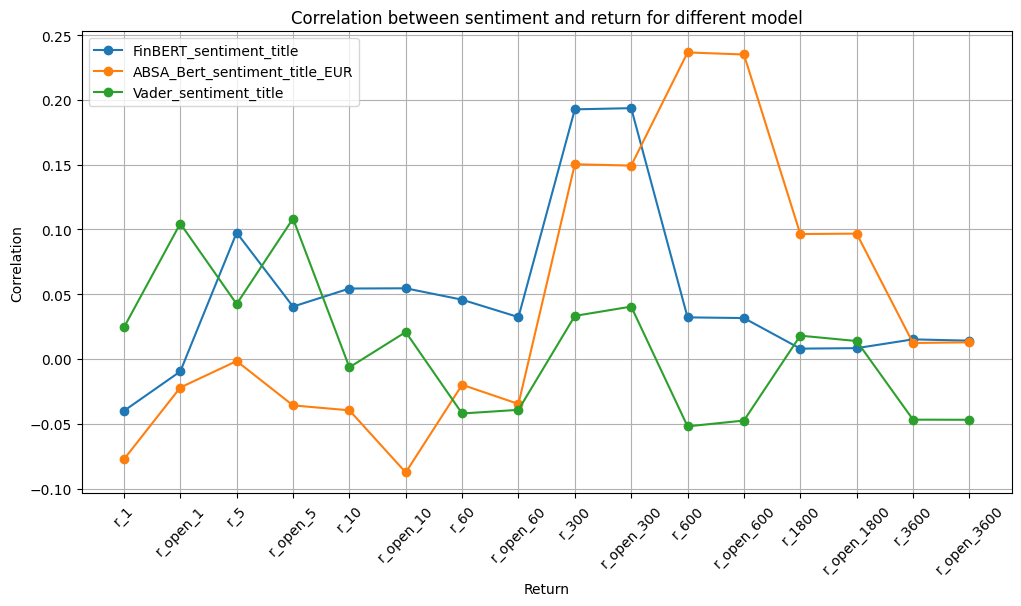

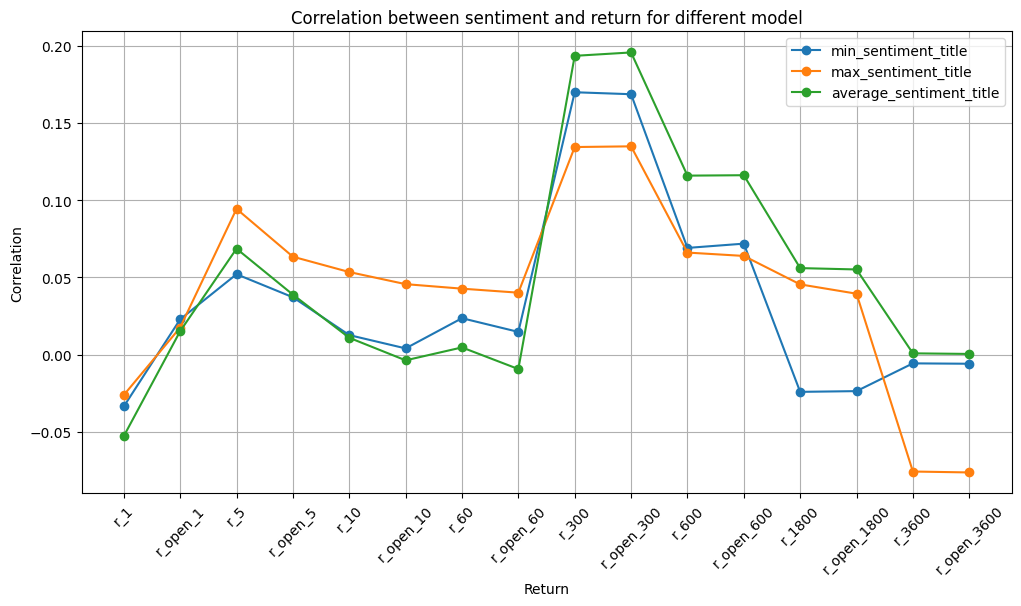

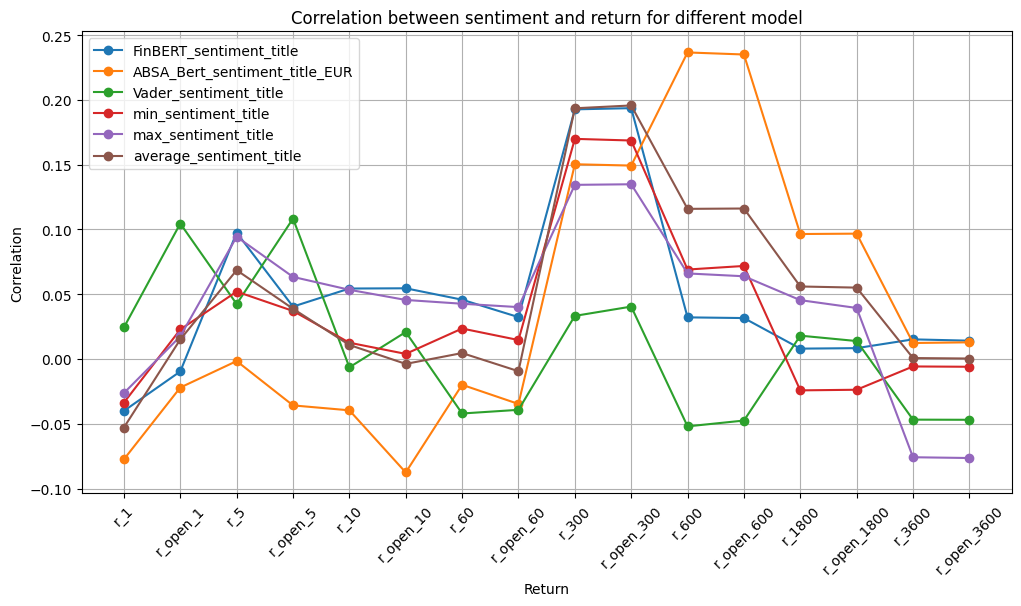

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

cols_list = [["FinBERT_sentiment_title", "ABSA_Bert_sentiment_title_EUR", "Vader_sentiment_title"], ["min_sentiment_title", "max_sentiment_title", "average_sentiment_title"],["FinBERT_sentiment_title", "ABSA_Bert_sentiment_title_EUR", "Vader_sentiment_title","min_sentiment_title", "max_sentiment_title", "average_sentiment_title"]]
x_cols = ["r_1", "r_open_1", "r_5", "r_open_5", "r_10", "r_open_10", "r_60", "r_open_60", "r_300", "r_open_300", "r_600", "r_open_600", "r_1800", "r_open_1800", "r_3600", "r_open_3600"]

for y_cols in cols_list:
    # Calculate the correlation matrix
    correlation_matrix = df[y_cols + x_cols].corr()
    
    plt.figure(figsize=(12, 6))
    
    # Iterate over each column in y_cols and plot individual line graphs
    for y_col in y_cols:
        correlation_values = correlation_matrix.loc[y_col, x_cols].values
        plt.plot(correlation_values, marker='o', label=y_col)
    
    plt.xticks(ticks=range(len(x_cols)), labels=x_cols, rotation=45)
    plt.xlabel('Return')
    plt.ylabel('Correlation')
    plt.title('Correlation between sentiment and return for different model')
    plt.legend()
    plt.grid(True)
    plt.show()

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a futur

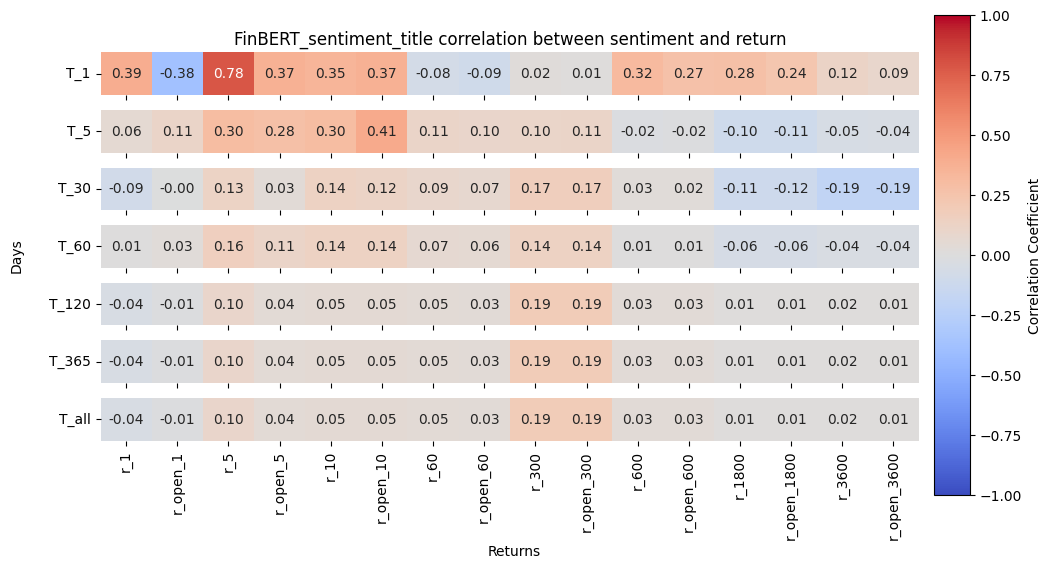

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a futur

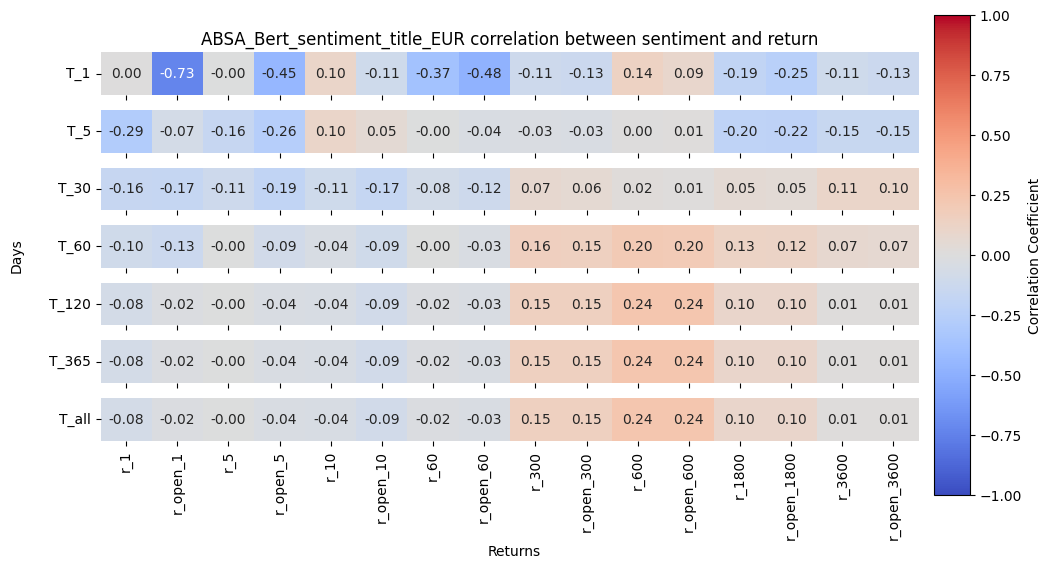

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a futur

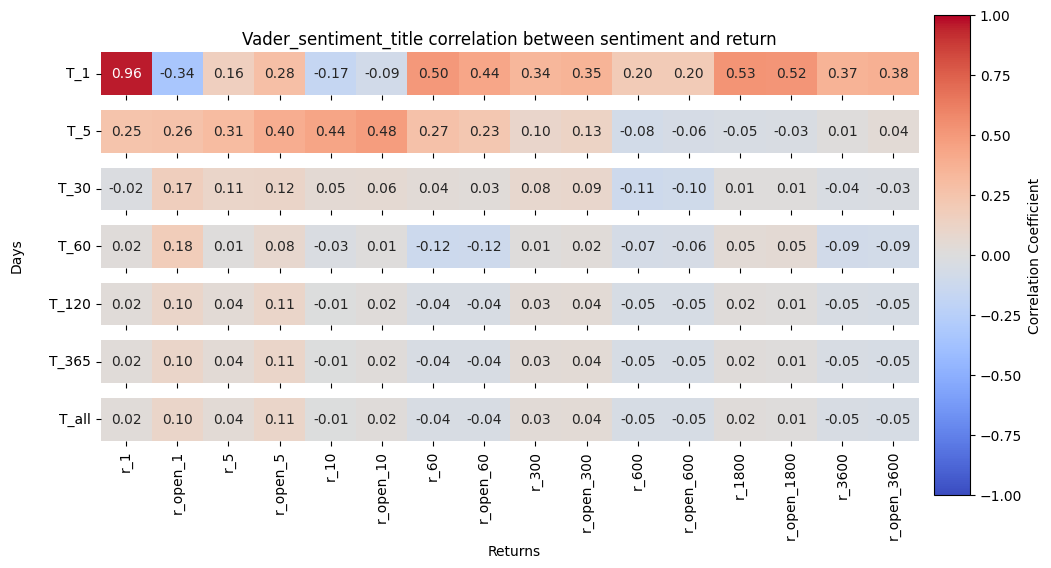

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a futur

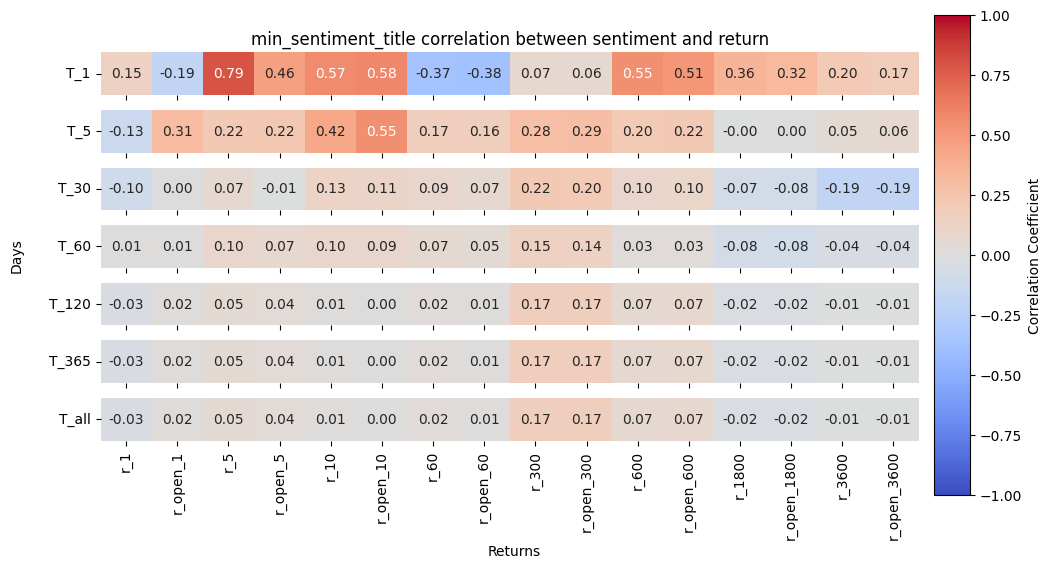

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a futur

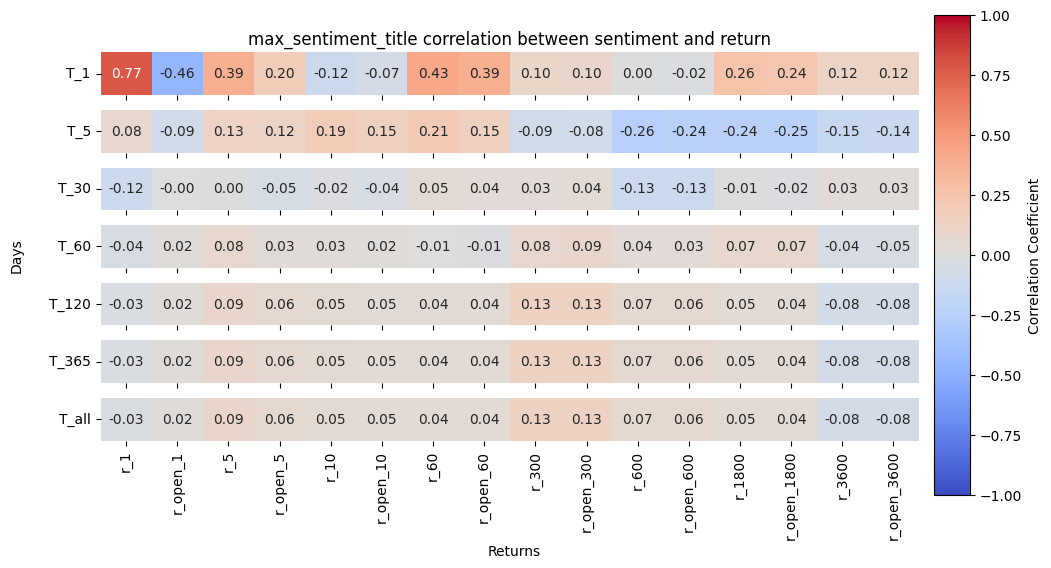

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_56314/2121513224.py:24: FutureWarning:

last is deprecated and will be removed in a futur

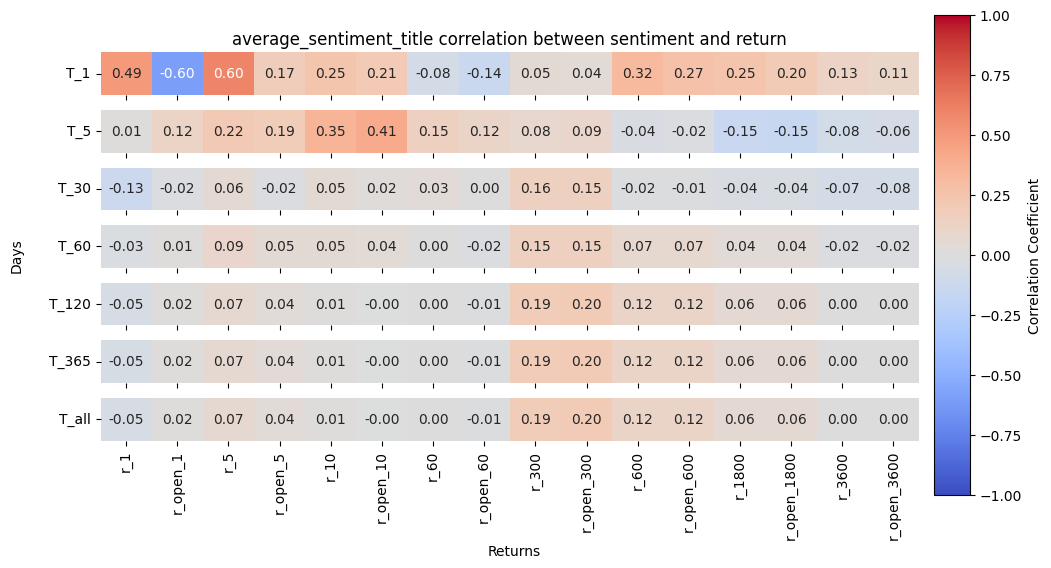

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

x_cols = ["r_1", "r_open_1", "r_5", "r_open_5", "r_10", "r_open_10", "r_60", "r_open_60", "r_300", "r_open_300", "r_600", "r_open_600", "r_1800", "r_open_1800", "r_3600", "r_open_3600"]
y_cols = ["FinBERT_sentiment_title", "ABSA_Bert_sentiment_title_EUR", "Vader_sentiment_title", "min_sentiment_title", "max_sentiment_title", "average_sentiment_title"]
time_periods = [1, 5, 30, 60, 120, 365, len(df)]

for col in y_cols:
    # Create subplots for each time period
    fig, axs = plt.subplots(nrows=len(time_periods), ncols=1, figsize=(12, 6))
    
    # Create a separate axis for the color bar on the right
    colorbar_ax = fig.add_axes([0.85, 0.2, 0.03, 0.8])  # Adjust position as necessary
    
    # Set a common color map and normalization
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    norm = plt.Normalize(-1, 1)
    
    for i, period in enumerate(time_periods):
        # Create new column name based on time period
        new_col = (f"T_all" if period == len(df) else f"T_{period}")
        
        # Filter the DataFrame for the last 'period' days
        df_period = df.last(f"{period}D").copy()
        df_period.rename(columns={col: new_col}, inplace=True)
        
        # Select columns for correlation analysis
        cols_to_corr = [new_col] + x_cols
        correlation_matrix = df_period[cols_to_corr].corr()
    
        # Create heatmap for the current period's correlation without color bar
        sns.heatmap(correlation_matrix.loc[[new_col], x_cols], 
                    ax=axs[i], 
                    annot=True, 
                    cmap=cmap, 
                    fmt=".2f", 
                    vmin=-1, 
                    vmax=1, 
                    cbar=False)  # Disable individual color bars
    
        # Set title for the first subplot
        if i == 0:
            axs[i].set_title(f"{col} correlation between sentiment and return")
    
        # Hide x-axis labels for all but the last subplot
        if i != len(time_periods) - 1:
            axs[i].set_xticklabels([])
    
        # Rotate y-axis tick labels for better readability
        axs[i].tick_params(axis='y', rotation=0)
    
    # Create a single color bar for all subplots
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for older versions of matplotlib
    cbar = plt.colorbar(sm, cax=colorbar_ax)
    cbar.set_label('Correlation Coefficient')
    
    # Set overall x and y labels
    fig.text(0.5, 0.1, 'Returns', ha='center')
    fig.text(0.08, 0.6, 'Days', va='center', rotation='vertical')
    
    # Adjust layout and display the plots
    plt.tight_layout(rect=[0.1, 0.1, 0.85, 1])  # Adjust layout to make space for the color bar
    plt.show()